In [1]:
# !pip3 install pandas numpy matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import scipy

In [2]:
sns.set()

# Preprocess

In [257]:
stdpso = pd.read_csv(f'data/raw/std_pso_{datetime.date.today()}.csv')
stdpso = stdpso[~stdpso.benchmark.isin([
    'Deb 3 Function',
    'Generalized Price 2 Function',
    'Mishra 7 Function',
#     'Mishra 1 Function',
    'Generalized Paviani Function',
])]

# Calculate standardised gbest \in [0, 1]
# min_gbest = stdpso.groupby(['benchmark', 'rep_num'])['gbest_fit'].transform('min')
# max_gbest = stdpso.groupby(['benchmark', 'rep_num'])['gbest_fit'].transform('max')
# range_gbest = max_gbest - min_gbest
# stdpso['norm_gbest'] = (stdpso['gbest_fit'] - min_gbest).div(range_gbest)

# Calculate log10_standardised_gbest
# stdpso['log10_norm_gbest'] = np.log10(stdpso['norm_gbest'])

responses = ['gbest_fit'] # , 'gdiversity', 'perc_oob', 'norm_gbest', 'log10_norm_gbest'
summ = stdpso.groupby(['benchmark', 'iter_num'])[responses] \
        .describe() \
        .loc[:,(slice(None),['mean', 'std', 'min', '50%', 'max'])] \
        .reset_index()
for multi_col in summ.columns:
    if multi_col[0] in responses:
        summ[(multi_col[0], 'mean_less_std')] = summ[(multi_col[0], 'mean')] - summ[(multi_col[0], 'std')] 
        summ[(multi_col[0], 'mean_plus_std')] = summ[(multi_col[0], 'mean')] + summ[(multi_col[0], 'std')] 
summ = summ.reindex(columns=sorted(summ.columns))
summ

benchmark  gbest_fit                                           \
                             50%           max         mean mean_less_std   
0      Brown Function  1022680.0  1.626100e+09  202923916.8 -3.011552e+08   
1      Brown Function  1022680.0  1.626100e+09  202923916.8 -3.011552e+08   
2      Brown Function  1022680.0  1.626100e+09  202923916.8 -3.011552e+08   
3      Brown Function  1022680.0  1.626100e+09  202923916.8 -3.011552e+08   
4      Brown Function  1022680.0  1.626100e+09  202923916.8 -3.011552e+08   
...               ...        ...           ...          ...           ...   
4135  Step 3 Function    69931.5  8.164200e+04      70528.7  6.227511e+04   
4136  Step 3 Function    69931.5  8.164200e+04      70528.7  6.227511e+04   
4137  Step 3 Function    69931.5  8.164200e+04      70528.7  6.227511e+04   
4138  Step 3 Function    69931.5  8.164200e+04      70528.7  6.227511e+04   
4139  Step 3 Function    69931.5  8.164200e+04      70528.7  6.227511e+04   

                                          iter_num  
     mean_plus_std      min           std           
0     7.070030e+08  20909.0  5.040791e+08        0  
1     7.070030e+08  20909.0  5.040791e+08        1  
2     7.070030e+08  20909.0  5.040791e+08        2  
3     7.070030e+08  20909.0  5.040791e+08        3  
4     7.070030e+08  20909.0  5.040791e+08        4  
...            ...      ...           ...      ...  
4135  7.878229e+04  58479.0  8.253588e+03     4500  
4136  7.878229e+04  58479.0  8.253588e+03     4600  
4137  7.878229e+04  58479.0  8.253588e+03     4700  
4138  7.878229e+04  58479.0  8.253588e+03     4800  
4139  7.878229e+04  58479.0  8.253588e+03     4900  

[4140 rows x 9 columns]

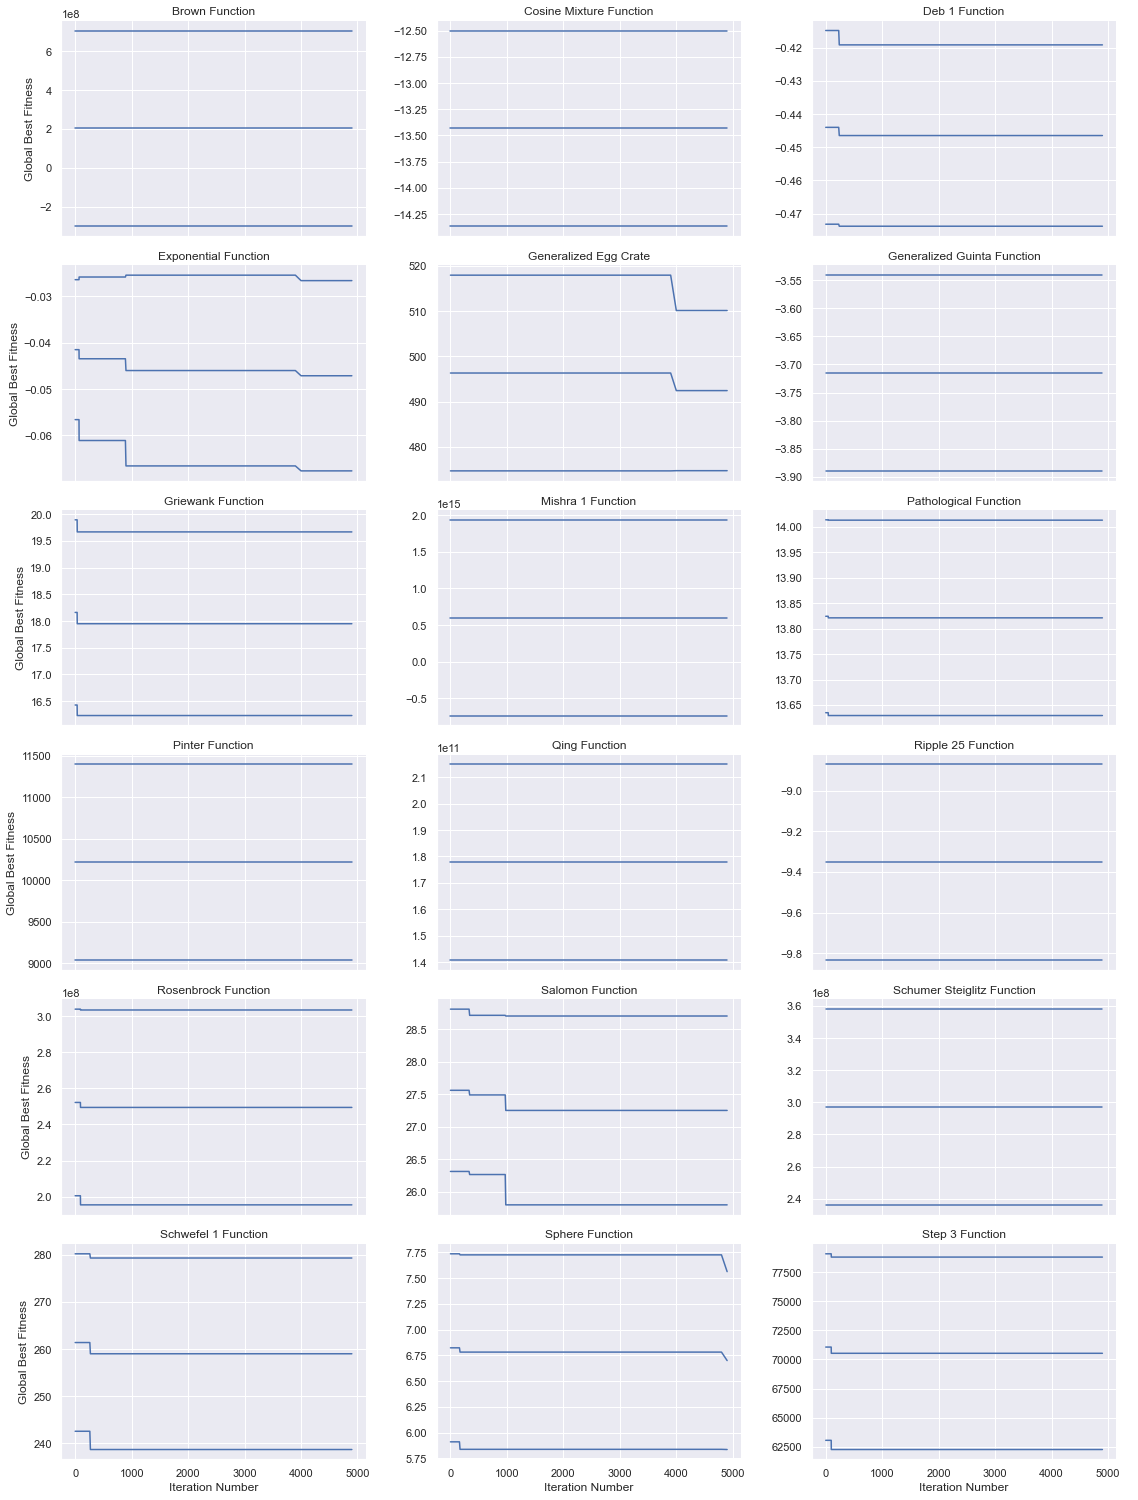

In [258]:
g = sns.FacetGrid(
    data=summ,
    col="benchmark", 
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
    sharey=False,
#     palette="flare",
)

def draw_lineplot(*args, **kwargs):
    data = kwargs.pop('data')
    ys = kwargs.pop('ys')
    for y in ys:
        sns.lineplot(data=data, y=y, **kwargs)

g.map_dataframe(
    draw_lineplot,
    x="iter_num",
    ys=[('gbest_fit', stat) for stat in ['mean_less_std', 'mean', 'mean_plus_std']],
)
g.add_legend()
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)
g.set_axis_labels("Iteration Number", "Global Best Fitness")
plt.savefig('../report/figs/gbest_fitness_standard_pso.pdf')

# Optimise Control Parameters per Benchmark

In [292]:
opt = pd.read_csv(f'data/raw/opt_{datetime.date.today()}.csv')
opt = opt[~opt.benchmark.isin([
    'Deb 3 Function',
    'Generalized Price 2 Function',
    'Mishra 7 Function',
#     'Mishra 1 Function',
    'Generalized Paviani Function',
])]

opt['c'] = np.round(opt['c1'] + opt['c2'], 4)
opt['w'] = np.round(opt['w'], 4)

## Heatmaps of Control Params

In [293]:
# TODO This gets the min, but really we want mean at 5000i
opt_gb = opt[opt.iter_num == 4900].groupby(['benchmark', 'w', 'c'])['gbest_fit'].std().sort_values().reset_index()
opt_gb['log_gbest'] = np.log10(opt_gb['gbest_fit'])
# opt_gb

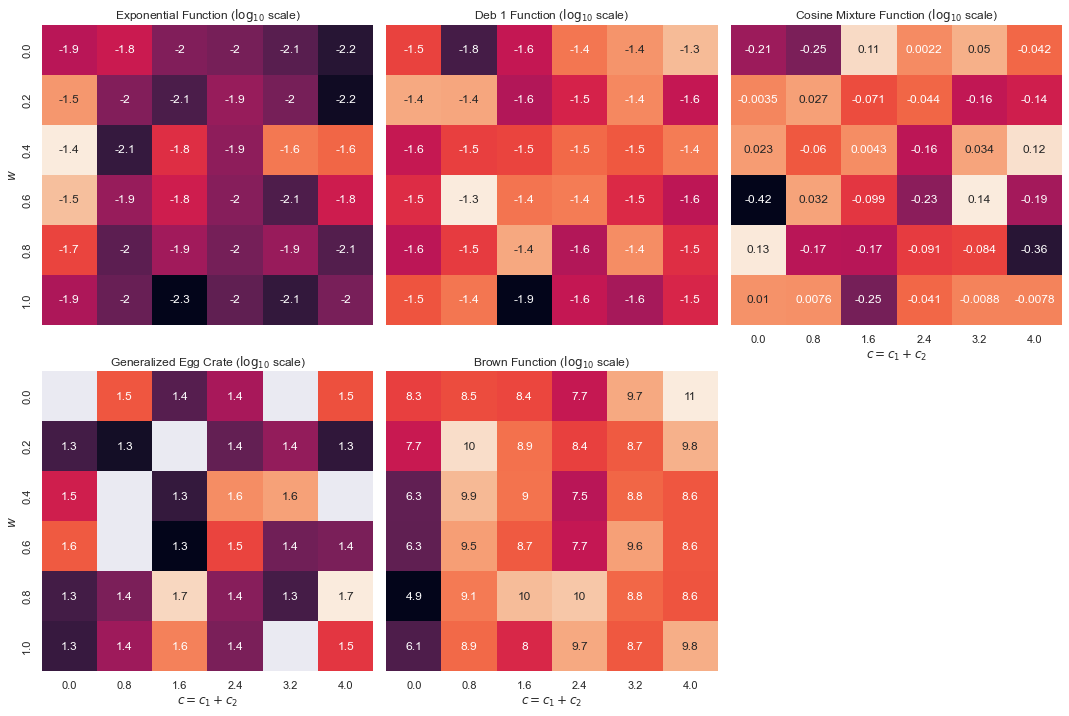

In [294]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(columns=args[0], index=args[1], values=args[2])
    sns.heatmap(d, **kwargs)

g = sns.FacetGrid(opt_gb,
                  col='benchmark', 
                  col_wrap=3, 
                  palette="CMRmap", # or "magma"
                  height=5)

g.map_dataframe(draw_heatmap, 'c', 'w', 'log_gbest', 
                cbar=False, annot=True, xticklabels=True, yticklabels=True)

g.set_titles(
    col_template="{col_name} ($\log_{{10}}$ scale)", 
)
g.set_axis_labels("$c=c_1+c_2$", "$w$")
# g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('Heatmap of Global Best Fitness values by Control Parameter\n $\log_{10}(fitness)$')
# plt.tight_layout()
plt.savefig('../report/figs/heatmaps.pdf')
# TODO also add poli boundary

## Best fitness value over time

In [240]:
opt_ot = opt.groupby(['benchmark','w', 'c', 'iter_num']).gbest_fit.mean().reset_index()
opt_ot['log_gbest'] = np.log10(opt_ot['gbest_fit'])
opt_ot

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,benchmark,w,c,iter_num,gbest_fit,log_gbest
0,Brown Function,0.0,0.0,0,2.489661e+07,7.39614
1,Brown Function,0.0,0.0,1,2.489661e+07,7.39614
2,Brown Function,0.0,0.0,2,2.489661e+07,7.39614
3,Brown Function,0.0,0.0,3,2.489661e+07,7.39614
4,Brown Function,0.0,0.0,4,2.489661e+07,7.39614
...,...,...,...,...,...,...
49215,Cosine Mixture Function,1.0,4.0,4500,-1.355190e+01,NaN
49216,Cosine Mixture Function,1.0,4.0,4600,-1.355190e+01,NaN
49217,Cosine Mixture Function,1.0,4.0,4700,-1.355190e+01,NaN
49218,Cosine Mixture Function,1.0,4.0,4800,-1.355190e+01,NaN


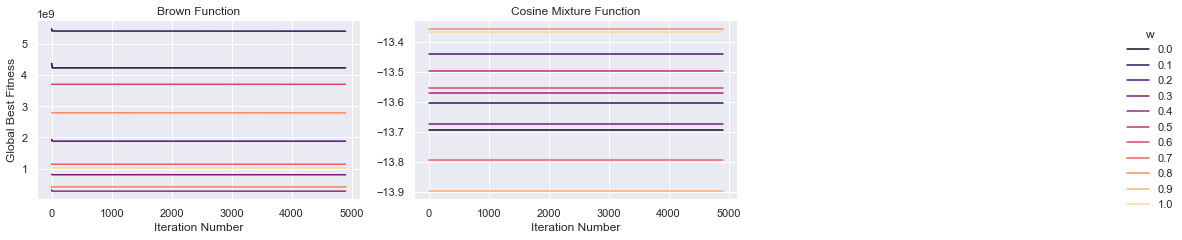

In [256]:
g = sns.FacetGrid(
    data=opt, 
    col="benchmark",
    hue='w',
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
    sharey=False,
    palette="magma"
)
g.map(
    sns.lineplot, 
    "iter_num", 
    "gbest_fit",
#     units='w',
#     estimator=None,
    ci=None
)
g.add_legend()
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)
g.set_axis_labels("Iteration Number", "Global Best Fitness")
# g.fig.subplots_adjust(top=0.93)
# g.fig.suptitle('Global best fitness per function over time')
# plt.savefig('../report/figs/gbest_fitness_standard_pso.pdf')

# Old work

In [ ]:
full_df.info()

In [ ]:
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.loc[full_df['gbest_fit'] < -1e+50, 'gbest_fit'] = -1e+50
full_df.loc[full_df['gbest_fit'] >  1e+50, 'gbest_fit'] =  1e+50
bad_funcs = [
    'Cosine Mixture Function',
    'Exponential Function',
    'Generalized Paviani Function',
    'Mishra 1 Function'
]

# Remove useless info
df = full_df[~full_df.benchmark.isin(bad_funcs) & full_df.gbest_fit.notna()]

# Define a standardised gbest
min_gbest = df['gbest_fit'].groupby(df['benchmark']).transform('min')
max_gbest = df['gbest_fit'].groupby(df['benchmark']).transform('max')
range_gbest = max_gbest - min_gbest
df['standardised_gbest'] = (df['gbest_fit'] - min_gbest).div(range_gbest)

# Define c = c1 + c2
df['c'] = df['c1'] + df['c2']

df.describe()

In [ ]:
print(f'benchmark unique {df.benchmark.unique()}')

# Make plots

## Evaluate $w=0.7$,  $c_1=c_2=1.4$

This happens when $dist=0$ via a special case

In [ ]:
g = sns.FacetGrid(
    data=df.loc[df['dist'] == 0, ['rep_num', 'gbest_fit', 'iter_num', 'benchmark']], 
    col="benchmark", 
#     hue='dist',
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
    sharey=False,
    palette="flare"
)
g.map(
    sns.lineplot, 
    "iter_num", 
    "gbest_fit",
    ci=None
)
g.add_legend()
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)
g.set_axis_labels("Iteration Number", "Global Best Fitness")
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Global best fitness per function over time')
plt.savefig('../report/figs/gbest_fitness_standard_pso.pdf')

### Evaluate swarm diversity

In [ ]:
g = sns.FacetGrid(
    data=df.loc[df['dist'] == 0, ['rep_num', 'gdiversity', 'iter_num', 'benchmark']], 
    col="benchmark", 
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
    sharey=False,
    palette="flare"
)
g.map(
    sns.lineplot, 
    "iter_num", 
    "gdiversity",
    ci=None
)
g.add_legend()
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)
g.set_axis_labels("Iteration Number", "Diversity")
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Diversity per function over time')
plt.savefig('../report/figs/diversity_standard_pso.pdf')

## Plot of $w$ vs $c_1+c_2$

In [ ]:
plot_df = df[['dist', 'w', 'c1', 'c2']].drop_duplicates().sort_values('dist')
plot_df['c'] = plot_df['c1'] + plot_df['c2']
ax = sns.scatterplot(
    data=plot_df, 
    x="c", 
    y="w", 
    hue="dist"
)
sns.move_legend(ax, "center right")

def add_poli():
    w = np.arange(0, 1.005, 0.01)
    c = (24 - 24 * w * w) / (7 - 5 * w)
    plt.plot(
        c,
        w,
        c='grey'
    )
    plt.plot(
        [c[-1], 0, 0, c[0]],
        [w[-1], 1, 0, w[0]],
        c='lightgrey'
    )
    plt.scatter(
        x=[1.4+1.4], y=[0.7],
        c='steelblue',
        marker='o'
    )
    ax.set(xlim=(-0.1, 5.2), ylim=(-0.05, 1.05))
add_poli()
plt.suptitle('Control Parameters: $w$ against $c$')
plt.title('Coloured by distance to Poli Stability boundary')
plt.xlabel('$c=c_1+c_2$')
plt.ylabel('$w$')
plt.savefig('../report/figs/w_vs_c.pdf')

## Find optimal parameters for each benchmark

In [ ]:
df['std_best_gbest'] = df.groupby(['benchmark', 'w', 'c1', 'c2', 'max_stagnent_iters', 'rep_num']).standardised_gbest \
    .transform('min')

In [ ]:
# sns.scatterplot(
#     data=df[df.benchmark == 'Step 3 Function'],
#     x='c',
#     y='w',
#     hue='standardised_gbest'
# )
# add_poli()

g = sns.FacetGrid(
    data=df[(df.rep_num == 1)], 
    col="benchmark", 
    hue='std_best_gbest',
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
#     sharey=False,
    palette="flare"
)

g.map(
    sns.scatterplot,
    "c", 
    "w",
    ci=None
)
# g.add_legend()
# g.set_titles(
#     col_template="{col_name}", 
# #     row_template="{row_name}"
# )
# g.set(ylim=(0, 1))
# g.fig.subplots_adjust(top=0.93)
# g.fig.suptitle('Global best fitness for various control parameters')
# g.set_axis_labels("Iteration Number", "Standardised global best fitness")
# plt.savefig('../report/figs/tmp.pdf')

## Investigate the effect of distance to boundary on CPs

Make some plots of how well each distance performed over time

In [ ]:
g = sns.FacetGrid(
    data=df[(df.iter_num < 5001)], 
    col="benchmark", 
    hue='dist',
    col_wrap=3,
    height=3.5, 
    aspect=1.5,
#     sharey=False,
    palette="flare"
)
g.map(
    sns.lineplot, 
    "iter_num", 
    "standardised_gbest",
    ci=None
)
g.add_legend()
g.set_titles(
    col_template="{col_name}", 
#     row_template="{row_name}"
)
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Global best fitness for various control parameters')
g.set_axis_labels("Iteration Number", "Standardised global best fitness")
plt.savefig('../report/figs/gbest_by_dist.pdf')